<a href="https://colab.research.google.com/github/alexferrero23/twitter-category-nlp/blob/develop/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re
import io

#### Select your file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving working_df.orc to working_df.orc


In [3]:
import pyarrow.orc 

df = pd.read_orc('working_df.orc')

In [4]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3.0,17.0,263
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1.0,0.0,62
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2.0,3.0,262
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3.0,29.0,163
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2.0,6.0,182


#### Let's create a column with a list of words from tweets

In [5]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
import string
list_of_rubish = ['&amp;', '-', '…', '’', '“', '—', '”', 'amp'] #stop_words.extend(("amp"))

def create_corpus_column(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    cleaned_corpus = []
    corpus = tokenizer.tokenize(tweet)
    for word in corpus:
        if (word not in stop) and (word not in list_of_rubish) and (word not in string.punctuation):
             cleaned_corpus.append(word)
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df['text_corpus'] = df['text'].apply(create_corpus_column)

In [7]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3.0,17.0,263,"[today, thoughts, entire, unc, charlotte, comm..."
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1.0,0.0,62,"[welcome, next, president, davidsoncollege, do..."
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2.0,3.0,262,"[workersmemorialday, remember, countless, work..."
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3.0,29.0,163,"[perfect, date, celebrate, 40th, anniversary, ..."
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2.0,6.0,182,"[happy, national, volunteer, week, volunteers,..."


#### First of all, I wanna check correlation between the two groups

In [ ]:
# Unnest of text_corpus
df_tidy = df.explode(column='text_corpus')
df_tidy = df_tidy.drop(columns='text')
df_tidy.head(3)

,username,created_at,lang,label,retweet_count,favorite_count,length,text_corpus
0,RepAdams,2022-04-30 14:42:28,en,D,3.0,17.0,263,today
0,RepAdams,2022-04-30 14:42:28,en,D,3.0,17.0,263,thoughts
0,RepAdams,2022-04-30 14:42:28,en,D,3.0,17.0,263,entire


In [ ]:
# Data pivot by label
df_pivot = df_tidy.groupby(["label","text_corpus"])["text_corpus"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "text_corpus" , columns="label", values= "count")
df_pivot.columns.name = None

In [ ]:
# Consine similarity
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivot.corr(method=similitud_coseno)

,D,R
D,1.000000,0.914954
R,0.914954,1.000000


#### ***This is actually really bad news, if there is a big correlation between both groups, its gonna be really difficult to say whether a tweet tends to be republican or democrat***

---



#MODEL
#### For the feature extraction, I'm gonna use Tf-idf (Term frequency – Inverse document frequency) -> Weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise
For model purposes, lets change label from letters to numbers: R -> 0 and D -> 1:


In [8]:
df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

In [29]:
#train-test split
from sklearn.model_selection import train_test_split

datos_X = df.text
datos_y = df.label_number

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [30]:
#check of proportions in both sets
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 44.5375417549372, 1: 55.4624582450628}
{0: 44.665432425284315, 1: 55.334567574715685}


In [31]:
#Tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    corpus = tokenizer.tokenize(tweet)
    return corpus

vectorizer  = TfidfVectorizer(
                        tokenizer  = tokenize,
                        min_df     = 5 #might change
                    )
vectorizer.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=5, tokenizer=<function tokenize at 0x7f1dcccafcb0>)

In [32]:
tfidf_train = vectorizer.transform(X_train)
tfidf_test  = vectorizer.transform(X_test)

In [33]:
print(f"Number of tokens created: {len(vectorizer.get_feature_names_out())}");

Number of tokens created: 55310


#### Function to visualize the embeddings in 2 dimensions:

In [14]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Republicans')
            green_patch = mpatches.Patch(color='blue', label='Democrats')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

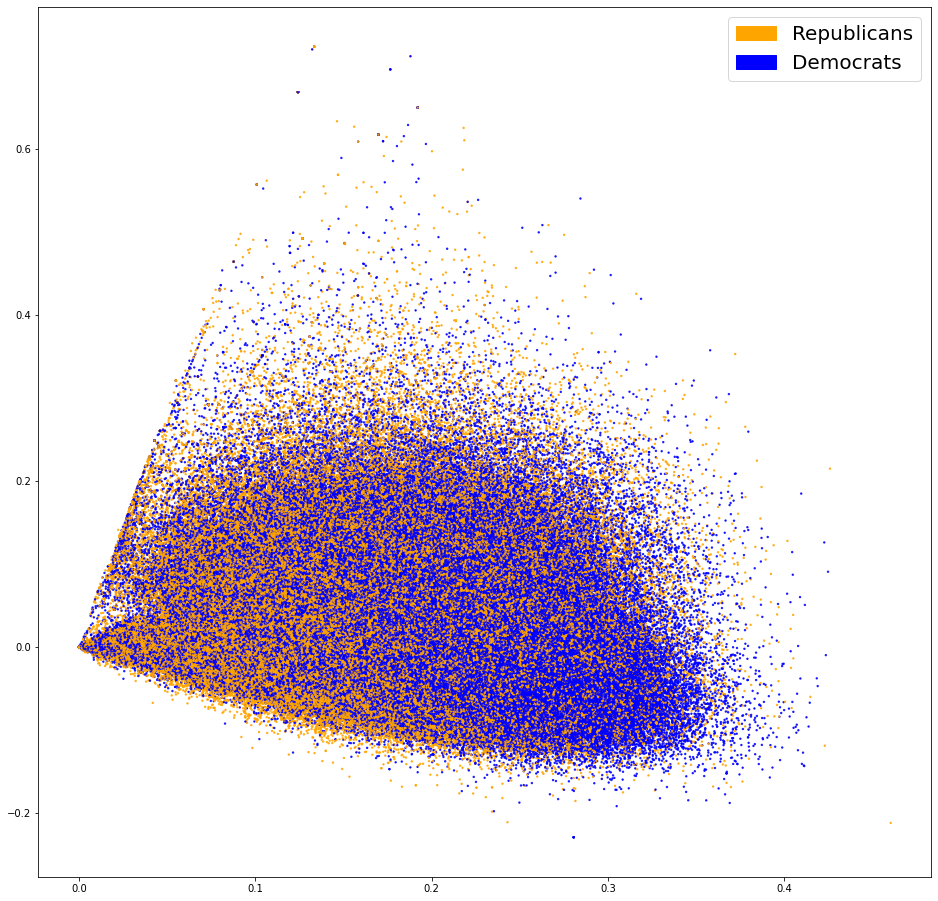

In [15]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidf_train, y_train)
plt.show()

#### Considering the quantity of data we are using, let's say that these embeddings look more or less separated. Now, we check performance with a logistic regression:




In [ ]:
%%time

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
log_reg.fit(tfidf_train, y_train)

y_hat = log_reg.predict(tfidf_test)

CPU times: user 2.7 s, sys: 916 ms, total: 3.62 s
Wall time: 6min 56s


#### Function to compute accuracy, precision, recall and f1 metrics

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_hat): 
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_hat)

    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_hat, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_hat, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_hat, pos_label=None, average='weighted')
    

    return accuracy, precision, recall, f1

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

accuracy = 0.8483522877545623, precision = 0.8491151432333724, recall = 0.8483522877545623, f1 = 0.8485561032024864


In [ ]:
prop_1s = len(df[df['label_number']==1])/len(df)
print(f'Proportion of 1\'s in label_number in the dataset: {prop_1s}')

Proportion of 1's in label_number in the dataset: 0.5543688005687396


#### In order to believe the value of the accuracy, per definition, it has to be bigger than the proportion of 1 in label_number in the dataset, which is correct

#### Confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_hat):
  
  conf_matrix = confusion_matrix(y_test, y_hat)
  plt.figure(figsize = (7,5))
  sns.heatmap(conf_matrix, annot=True, fmt='g');


In [ ]:
create_confusion_matrix(y_test, y_hat)

#### ROC Curve and area under the ROC Curve

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

def create_roc_curve(model, y_test, y_train):

  fig = plt.figure(figsize=(10, 10))          

  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_test)[:, 1])
  plt.plot(fpr, tpr);

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_train)[:, 1])
  plt.plot(fpr, tpr);

  print(f'ROC AUC SCORE: {roc_auc_score(y_test, model.predict_proba(tfidf_test)[:, 1])}')


In [ ]:
create_roc_curve(log_reg, y_test, y_train)

# PRETTY COOL, ADD CONCLUSIONS

These are really good results for a first try, but we don't know if they are the best. In order to discover that, I'm going to attemp a grid search for the logistic regression.

In [ ]:
param_grid = [{'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'classifier__solver' : ['liblinear']},
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'classifier__solver' : ['newton-cg', 'lbfgs']}]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipe = Pipeline([('classifier' , LogisticRegression())])

grid = GridSearchCV(pipe, param_grid = param_grid, verbose=True, n_jobs=-1)

In [ ]:
%%time

best_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
print('Best Score: %s' % best_clf.best_score_)
print('Best Hyperparameters: %s' % best_clf.best_params_)

Best Score: 0.8491730981280027
Best Hyperparameters: {'classifier': LogisticRegression(C=10, solver='liblinear'), 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [ ]:
best_model = best_clf.best_estimator_
y_hat = best_model.predict(tfidf_test)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

accuracy = 0.8501454641629199, precision = 0.8499619905235545, recall = 0.8501454641629199, f1 = 0.8499639409501694


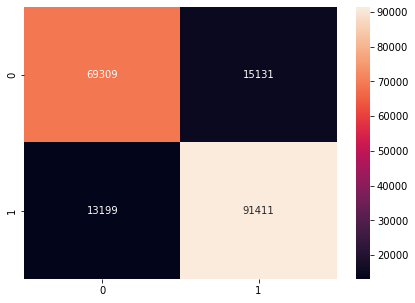

In [ ]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.9320961163706969


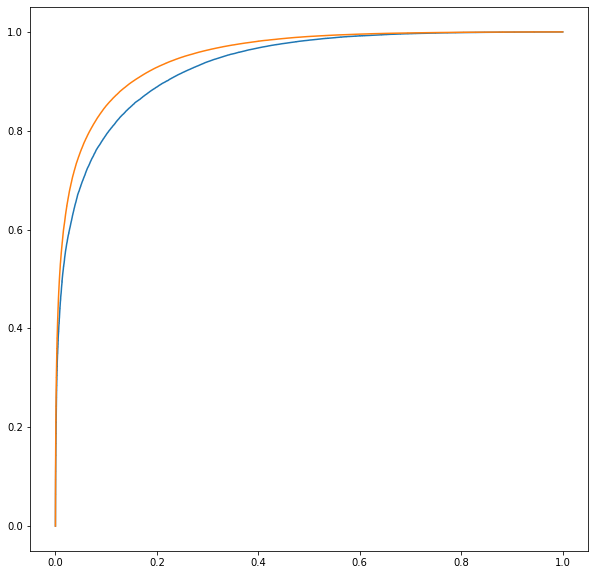

In [ ]:
create_roc_curve(best_model, y_test, y_train)

#### Slightly better performance

#### Random forest are really slow

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)

In [ ]:
%%time

#rf.fit(tfidf_train, y_train)

#rf.oob_score_

In [ ]:
#y_hat = rf.predict(tfidf_test)
#probs = rf.predict_proba(tfidf_test)

In [ ]:
#get_metrics(y_test, y_hat)

### Gradient boosting: 
#### Grid search seems to be really slow, which is normal as it does a search evaluating all possible parameters. Maybe it would be better to do a random grid search

In [ ]:
#param_grid = {'n_estimators'  : [50, 100, 500, 1000],
#              'max_features'  : ['auto', 'sqrt', 'log2'],
#              'max_depth'     : [None, 1, 3, 5, 10, 20],
#              'subsample'     : [0.5, 1],
#              'learning_rate' : [0.001, 0.01, 0.1]
3
#             }

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.model_selection import RepeatedKFold
#import multiprocessing

#grid = GridSearchCV(
#        estimator  = GradientBoostingClassifier(random_state=123),
#        param_grid = param_grid,
#        scoring    = 'accuracy',
#        n_jobs     = multiprocessing.cpu_count() - 1,
#        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
#        refit      = True,
#        verbose    = 0,
#        return_train_score = True
#       )

In [ ]:
#grid.fit(tfidf_train, y_train)

#1 hour and a half is enough to stop it tbh

In [ ]:
#resultados = pd.DataFrame(grid.cv_results_)

In [ ]:
#resultados

#### Random grid search

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
#import multiprocessing
#from sklearn.linear_model import Ridge

#param_distributions = {'parameters': np.logspace(-5, 3, 100)}

#grid = RandomizedSearchCV(
#        estimator  = LogisticRegression(),
#        param_distributions = param_distributions,
#        n_iter     = 50,
#        scoring    = 'neg_root_mean_squared_error',
#        n_jobs     = multiprocessing.cpu_count() - 1,
#        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
#        verbose    = 0,
#        random_state = 123,
#        return_train_score = True
#       )

In [ ]:
#grid.fit(tfidf_train, y_train)

#### XGBoost

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    )

In [35]:
%%time

xgb_model.fit(tfidf_train, y_train)

CPU times: user 12min 49s, sys: 1.19 s, total: 12min 50s
Wall time: 12min 48s


XGBClassifier(eval_metric='auc', max_depth=7, n_estimators=80,
              use_label_encoder=False)

In [38]:
y_hat = xgb_model.predict(tfidf_test)

In [39]:
y_test.shape

(189050,)

In [40]:
y_hat.shape

(189050,)

In [41]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_hat)
print(f'accuracy = {accuracy_tfidf}, precision = {precision_tfidf}, recall = {recall_tfidf}, f1 = {f1_tfidf}')

accuracy = 0.7085268447500661, precision = 0.7108086806858845, recall = 0.7085268447500661, f1 = 0.7022821947402127


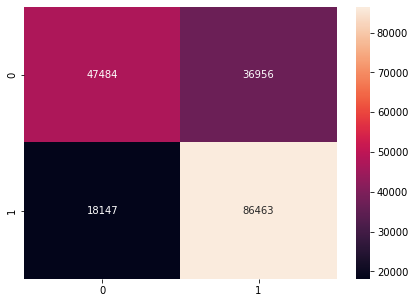

In [42]:
create_confusion_matrix(y_test, y_hat)

ROC AUC SCORE: 0.7948101609252584


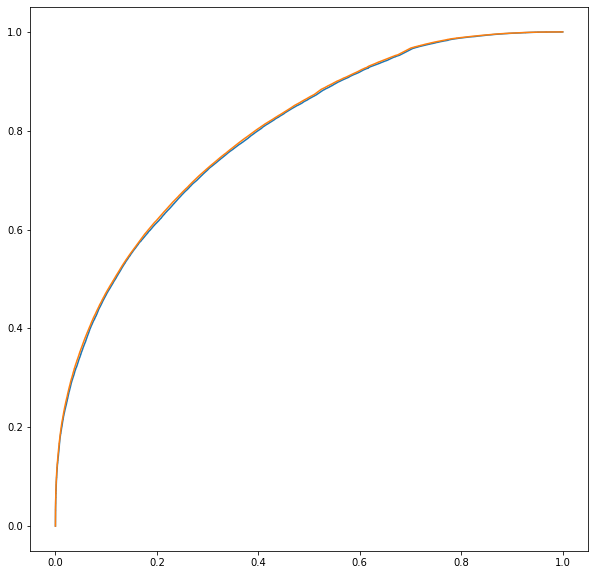

In [43]:
create_roc_curve(xgb_model, y_test, y_train)

ADD CONCLUSIONS WHAT A SHIT

#### Okay, now I wanna try word2vec to see if I can improve the model

In [ ]:
#!python -m gensim.downloader --download word2vec-google-news-300

In [ ]:
#import gensim

# Load Google's pre-trained Word2Vec model.
#word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)